# Imports

In [1]:
# %%bash

# git clone https://github.com/Qiwei97/Gym-PM.git
# cd Gym-PM
# pip install -e .

In [2]:
# Import Modules
import numpy as np
import gym
from gym.wrappers.normalize import NormalizeReward

import gym_pm
from gym_pm.utils import create_data, update_boundaries, evaluate_baseline, evaluate_policy, plot_metrics
from gym_pm.envs import Railv2_Env

import ray
from ray.tune.registry import register_env
from ray.rllib.agents import ppo

# Environment

In [3]:
def env_wrapper(env_config):

  wrapped_env = Railv2_Env(**env_config) # Use the appropriate env
  wrapped_env = NormalizeReward(wrapped_env)

  return wrapped_env  # return an env instance

env_name = "Rail-v2"
register_env(env_name, env_wrapper)

In [4]:
# # Update the data (Optional)
# # If the pickle files do not exist, please run the below code.
# data = 'PdM2'
# create_data(data, split='Train', save=True)
# create_data(data, split='Test', save=True)
# update_boundaries(data, save=True)

# Training

In [5]:
config = ppo.DEFAULT_CONFIG.copy()
# Training Params
config['seed'] = 1
config['batch_mode'] = 'complete_episodes'
config['exploration_config'] = {'type': 'SoftQ'}
config['entropy_coeff'] = 0.002
config['vf_clip_param'] = 1e5
config['kl_target'] = 0.03
# Multiprocessing
config["num_gpus"] = 0
config["num_workers"] = 16
# Preprocessing
config["observation_filter"] = 'MeanStdFilter'
config['preprocessor_pref'] = 'rllib'

trainer = ppo.PPOTrainer(config=config, env=env_name)

2022-03-18 08:42:40,021	WARNING ppo.py:231 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=16 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 250.
2022-03-18 08:42:54,902	INFO trainable.py:130 -- Trainable.setup took 14.881 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


In [6]:
# # Hyperparameter Tuning

# config['env'] = env_name

# analysis = ray.tune.run(
#     ppo.PPOTrainer,
#     config=config,
#     local_dir='Scripts/Tuning',
#     mode='max',
#     verbose=2,
#     stop={"episode_reward_mean": 100}
#     )

In [7]:
results = []

for i in range(int(1000)):

  res = trainer.train()
  results.append(res)

  if (i+1) % 10 == 0:
    print('Iter: {} Reward: {:.2f}'.format(i+1, res['episode_reward_mean']))

trainer.save('Models/Railv2/PPO')

2022-03-18 08:43:13,607	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
(RolloutWorker pid=6474) 2022-03-18 08:44:40,630	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Iter: 10 Reward: 562.02
Iter: 20 Reward: 611.04
Iter: 30 Reward: 678.19
Iter: 40 Reward: 743.98
Iter: 50 Reward: 804.21
Iter: 60 Reward: 851.88
Iter: 70 Reward: 889.68
Iter: 80 Reward: 931.56
Iter: 90 Reward: 963.56
Iter: 100 Reward: 991.66
Iter: 110 Reward: 1023.31
Iter: 120 Reward: 1044.99
Iter: 130 Reward: 1070.01
Iter: 140 Reward: 1094.11
Iter: 150 Reward: 1109.04
Iter: 160 Reward: 1122.22
Iter: 170 Reward: 1143.64
Iter: 180 Reward: 1163.08
Iter: 190 Reward: 1176.46
Iter: 200 Reward: 1184.06
Iter: 210 Reward: 1196.90
Iter: 220 Reward: 1209.02
Iter: 230 Reward: 1219.65
Iter: 240 Reward: 1227.87
Iter: 250 Reward: 1236.00
Iter: 260 Reward: 1247.03
Iter: 270 Reward: 1258.48
Iter: 280 Reward: 1266.10
Iter: 290 Reward: 1273.32
Iter: 300 Reward: 1281.14
Iter: 310 Reward: 1289.33
Iter: 320 Reward: 1295.90
Iter: 330 Reward: 1298.54
Iter: 340 Reward: 1304.56
Iter: 350 Reward: 1310.32
Iter: 360 Reward: 1316.42
Iter: 370 Reward: 1322.50
Iter: 380 Reward: 1326.86
Iter: 390 Reward: 1328.37
Iter:

2022-03-19 15:08:02,452	WARNING deprecation.py:46 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


Iter: 1000 Reward: 1462.30


'Models/Railv2/PPO/checkpoint_001000/checkpoint-1000'

# Evaluation

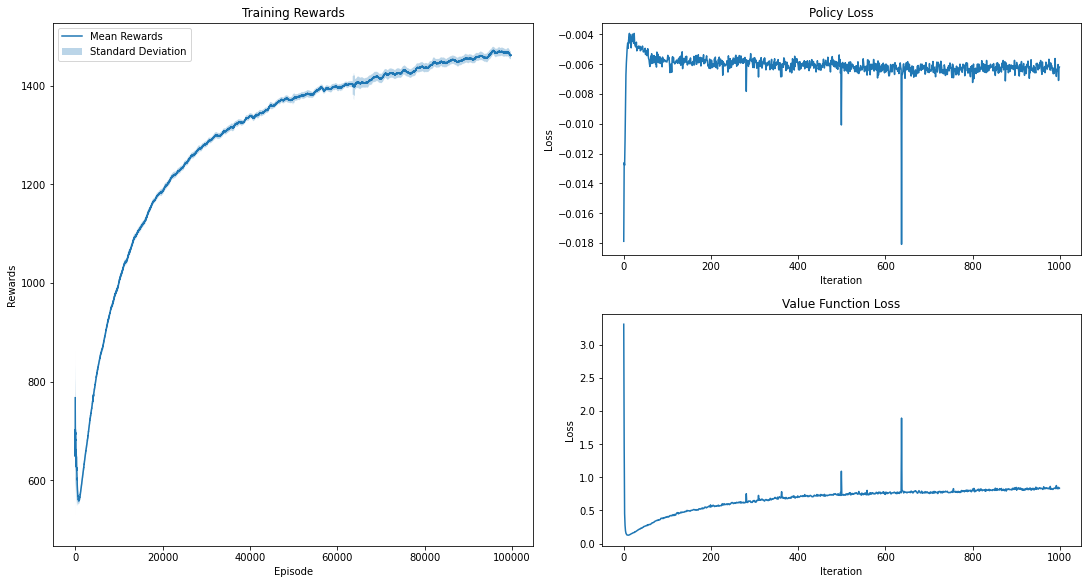

In [8]:
plot_metrics(results)

In [9]:
# trainer = ppo.PPOTrainer(config=config, env=env_name)
# trainer.restore('Models/Railv2/PPO/checkpoint_001000/checkpoint-1000')

In [10]:
eval_env = Railv2_Env(config, split='Test')

baseline = evaluate_baseline(eval_env,
                             repair_policy=1, 
                             repair_interval=10)

result = evaluate_policy(eval_env, trainer)

print('Baseline: {}'.format(baseline.reward.mean()))
print('Agent Performance: {}'.format(result.reward.mean()))

2022-03-19 15:08:52,733	WARNING deprecation.py:46 -- DeprecationWarning: `compute_action` has been deprecated. Use `Trainer.compute_single_action()` instead. This will raise an error in the future!


Baseline: 87.10602270540697
Agent Performance: 83.82528381758706


In [11]:
result.to_csv('Output/Railv2_PPO.csv')

In [12]:
agent, base0, base10 = [], [], []

for _ in range(5):
    agent.append(evaluate_policy(eval_env, trainer).reward.mean())
    base0.append(evaluate_baseline(eval_env,
                                   repair_policy=0).reward.mean())
    base10.append(evaluate_baseline(eval_env,
                                    repair_policy=1, 
                                    repair_interval=10).reward.mean())

print(np.mean(agent))
print(np.mean(base0))
print(np.mean(base10))

84.03386569174525
81.68712718876276
87.11833750240523


<BarContainer object of 40 artists>

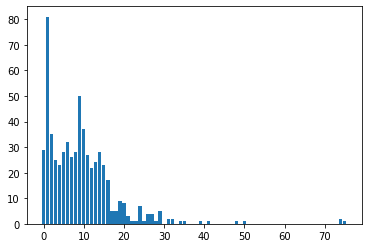

In [13]:
import matplotlib.pyplot as plt

result.action = result.action.shift(-1)

ttf_dist = result[result.action == 0].ttf.value_counts()
plt.bar(ttf_dist.index, ttf_dist)

<BarContainer object of 27 artists>

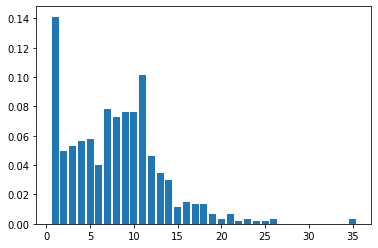

In [14]:
age_dist = result[result.action == 0].age.value_counts(normalize=True)
plt.bar(age_dist.index, age_dist)

In [15]:
# if ttf = 0, agent repair when failed